In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df_raw = pd.read_csv('hdb_resale_model_output_03_Apr.csv')

In [6]:
df = df_raw.dropna()

In [7]:
df.isna().sum()

Unnamed: 0             0
town                   0
flat_type              0
flat_model             0
floor_area_sqm         0
street_name            0
resale_price           0
month                  0
remaining_lease        0
lease_commence_date    0
storey_range           0
_id                    0
block                  0
address                0
latitude               0
longitude              0
min_dist_mrt           0
min_dist_mall          0
cbd_dist               0
lease_remain_years     0
price_per_sqm          0
price_per_sqm_pred     0
pred_error             0
_merge                 0
dtype: int64

## Feature Engineering

In [8]:
# Separate our numerical and categorical variables
cat_features = ['town', 'flat_type', 'storey_range']
num_features = ['min_dist_mrt', 'min_dist_mall', 'cbd_dist','floor_area_sqm', 'lease_remain_years', ]
target = ['price_per_sqm']

In [9]:
df_cat = df[cat_features]
df_num = df[num_features]
df_target = df[target]

In [10]:
# Mapping ordinal categories to their respective values
flat_type_map = {
    'EXECUTIVE': 7,
    'MULTI-GENERATION': 6,
    '5 ROOM': 5,
    '4 ROOM': 4,
    '3 ROOM': 3,
    '2 ROOM': 2,
    '1 ROOM': 1
}

df_cat['flat_type_mapped'] = df_cat['flat_type'].map(lambda x: flat_type_map[x])

In [11]:
def split_mean(x):
    split_list = x.split(' TO ')
    mean = (float(split_list[0])+float(split_list[1]))/2
    return mean

df_cat['storey_mean'] = df_cat['storey_range'].apply(lambda x: split_mean(x))

In [12]:
# One-Hot Encoding for'town' and drop 1 of our dummy variables
df_cat = pd.get_dummies(data=df_cat, columns=['town'], drop_first=True)

In [13]:
# Inspect categorical features
df_cat = df_cat.drop(['flat_type', 'storey_range'], axis=1)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106323 entries, 0 to 106571
Data columns (total 27 columns):
flat_type_mapped        106323 non-null int64
storey_mean             106323 non-null float64
town_BEDOK              106323 non-null uint8
town_BISHAN             106323 non-null uint8
town_BUKIT BATOK        106323 non-null uint8
town_BUKIT MERAH        106323 non-null uint8
town_BUKIT PANJANG      106323 non-null uint8
town_BUKIT TIMAH        106323 non-null uint8
town_CENTRAL AREA       106323 non-null uint8
town_CHOA CHU KANG      106323 non-null uint8
town_CLEMENTI           106323 non-null uint8
town_GEYLANG            106323 non-null uint8
town_HOUGANG            106323 non-null uint8
town_JURONG EAST        106323 non-null uint8
town_JURONG WEST        106323 non-null uint8
town_KALLANG/WHAMPOA    106323 non-null uint8
town_MARINE PARADE      106323 non-null uint8
town_PASIR RIS          106323 non-null uint8
town_PUNGGOL            106323 non-null uint8
town_QUEENSTO

In [14]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106323 entries, 0 to 106571
Data columns (total 5 columns):
min_dist_mrt          106323 non-null float64
min_dist_mall         106323 non-null float64
cbd_dist              106323 non-null float64
floor_area_sqm        106323 non-null float64
lease_remain_years    106323 non-null float64
dtypes: float64(5)
memory usage: 4.9 MB


## Train, Test, Split

In [29]:
# Train, test, splot
X = df_cat.join(df_num)
y = df_target
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

## Import Evaluation Metrics for ML Modls

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

## Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
lm_reg = LinearRegression().fit(X, y)

### Linear Regression Model Evaluation MSE

In [33]:
# Compute y_pred_lm
y_pred_lm = lm_reg.predict(X_test)

# Compute rmse_lm
mse_lm = MSE(y_test, y_pred_lm)

# Compute rmse_lm
rmse_lm = mse_lm**(1/2)

# Print rmse_lm
print("Test set RMSE of Linear Regression: {:.2f}".format(rmse_lm))

Test set RMSE of Linear Regression: 508.02


In [47]:
# Create a pd.Series of features importances
lm_coef = lm_reg.coef_
lm_coef

array([[ 1.98714506e+02,  4.73755877e+01, -9.71205557e+01,
         6.40635116e+02, -3.93612931e+02,  7.70647323e+01,
        -6.52314837e+02,  1.56585818e+03,  3.63314053e+02,
        -8.93531638e+02,  4.35888899e+02, -3.04906929e+02,
        -6.72564271e+02,  4.60828475e+01, -2.46141883e+02,
        -2.33213024e+02,  2.02638848e+03, -5.41798404e+01,
        -7.10903689e+02,  5.96373000e+02, -8.04663596e+02,
        -9.52720933e+02,  7.67384396e+01,  6.06047760e+01,
        -1.29492767e+02, -4.72049548e+02, -2.12911414e+02,
        -6.41809595e-01, -2.17607383e-01, -1.53192488e-01,
        -9.62867155e+00,  5.47224033e+01]])

### 10-Fold Validation: Linear Regression

In [73]:
lm_cv_scores = cross_val_score(lm_reg, X, y, cv=10, scoring="neg_mean_squared_error")

# Print the 10-fold cross-validation scores
print(lm_cv_scores)
lm_cv_score_rmse = abs(lm_cv_scores)**(1/2)
print(lm_cv_score_rmse)

print("Average 10-Fold CV Score: {}".format(np.mean(lm_cv_score_rmse)))

[-257235.947738   -252408.84681916 -244989.54915648 -252523.37936505
 -245996.88997162 -260497.01191973 -257424.34079501 -253884.23320689
 -258037.64071427 -280108.80342518]
[507.1843331  502.40307206 494.96418977 502.51704386 495.98073548
 510.38907896 507.37002355 503.86926202 507.97405516 529.2530618 ]
Average 5-Fold CV Score: 506.1904855754725


## Lasso Regression

In [90]:
# Import Lasso
from sklearn.linear_model import Lasso

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True).fit(X, y)

In [91]:
# Compute y_pred_lasso
y_pred_lasso = lasso.predict(X_test)

# Compute rmse_lasso
mse_lasso = MSE(y_test, y_pred_lasso)

# Compute rmse_lasso
rmse_lasso = mse_lasso**(1/2)

# Print rmse_lasso
print("Test set RMSE of Linear Regression: {:.2f}".format(rmse_lasso))

Test set RMSE of Linear Regression: 682.99


In [92]:
# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

[  0.          40.91637989  -0.           0.          -0.
   0.          -0.           0.           0.          -0.
   0.          -0.          -0.           0.           0.
  -0.           0.           0.           0.         146.57937696
  -0.          -0.           0.           0.          -0.
  -0.           0.          -0.31503391  -0.          -0.15161542
  -0.          29.56006367]


In [100]:
# Create a pd.Series of features importances
lasso_importance = pd.Series(data=lasso.coef_,
                        index= X_train.columns)

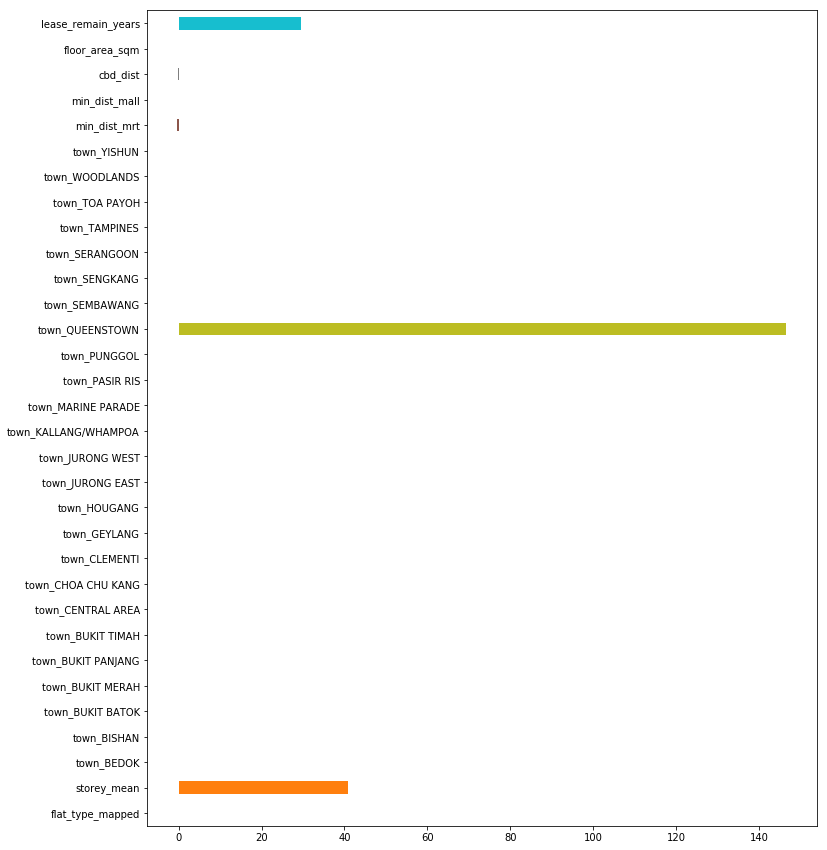

In [101]:
# Plot the coefficients
plt.figure(figsize=(12,15))
lasso_importance.plot(kind="barh")
plt.show()

## Regression Tree

In [78]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

In [81]:
rt = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=0.13,
            random_state=3)

# Fit dt to the training set
rt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.13,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=3, splitter='best')

### Regression Tree Model Evaluation MSE

In [83]:
# Compute y_pred
y_pred_rt = rt.predict(X_test)

# Compute mse_dt
mse_rt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_rt = mse_rt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_rt))

Test set RMSE of dt: 893.81


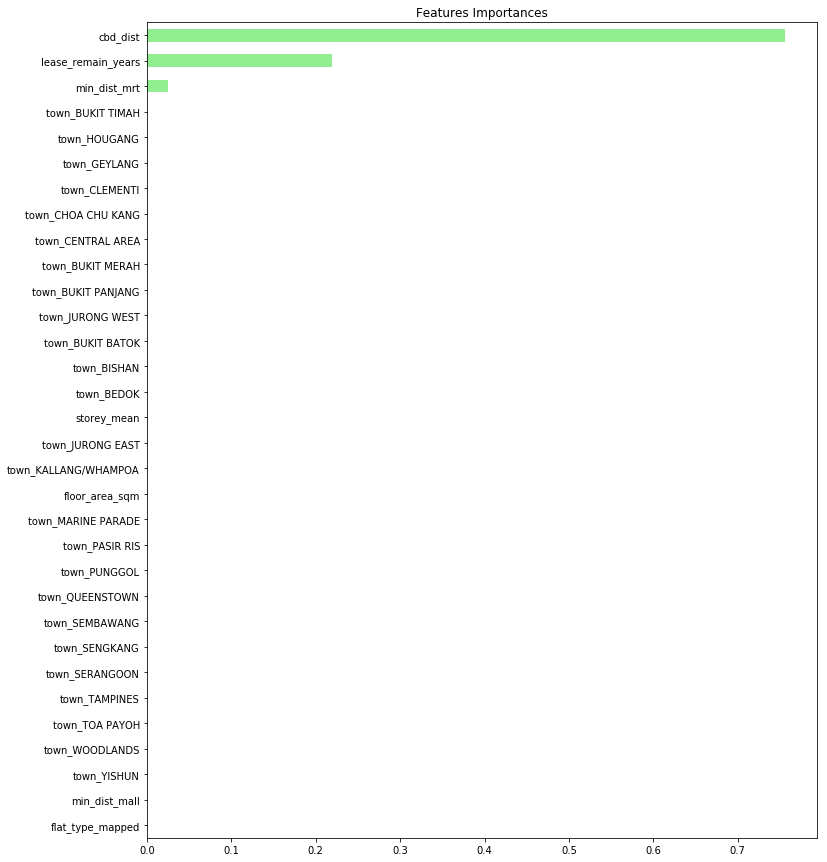

In [84]:
# Create a pd.Series of features importances
rt_importances = pd.Series(data=rt.feature_importances_,
                        index= X_train.columns)

# Sort importances
rt_importances_sorted = rt_importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(12,15))
rt_importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [86]:
rt_cv_scores = cross_val_score(rt, X, y, cv=10, scoring="neg_mean_squared_error")

# Print the 10-fold cross-validation scores
print(rt_cv_scores)
rt_cv_score_rmse = abs(rt_cv_scores)**(1/2)
print(rt_cv_score_rmse)

print("Average 10-Fold CV Score: {}".format(np.mean(rt_cv_score_rmse)))

[-726719.12752119 -731915.69265307 -759777.34968112 -766832.54037436
 -798531.82871966 -843966.7663572  -798192.47228264 -777792.24329631
 -830065.30594696 -847504.08442352]
[852.47822701 855.52071433 871.65208064 875.68975121 893.6060814
 918.67663863 893.41618089 881.92530483 911.0791985  920.59985033]
Average 5-Fold CV Score: 887.4644027771021


## Random Forest Regression

In [37]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

### Random Forest Regressior Model Evaluation MSE

In [38]:
# Predict the test set labels
y_pred_rf = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test_rf = (MSE(y_test, y_pred_rf))**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_rf))

Test set RMSE of rf: 233.48


### Feature Importance

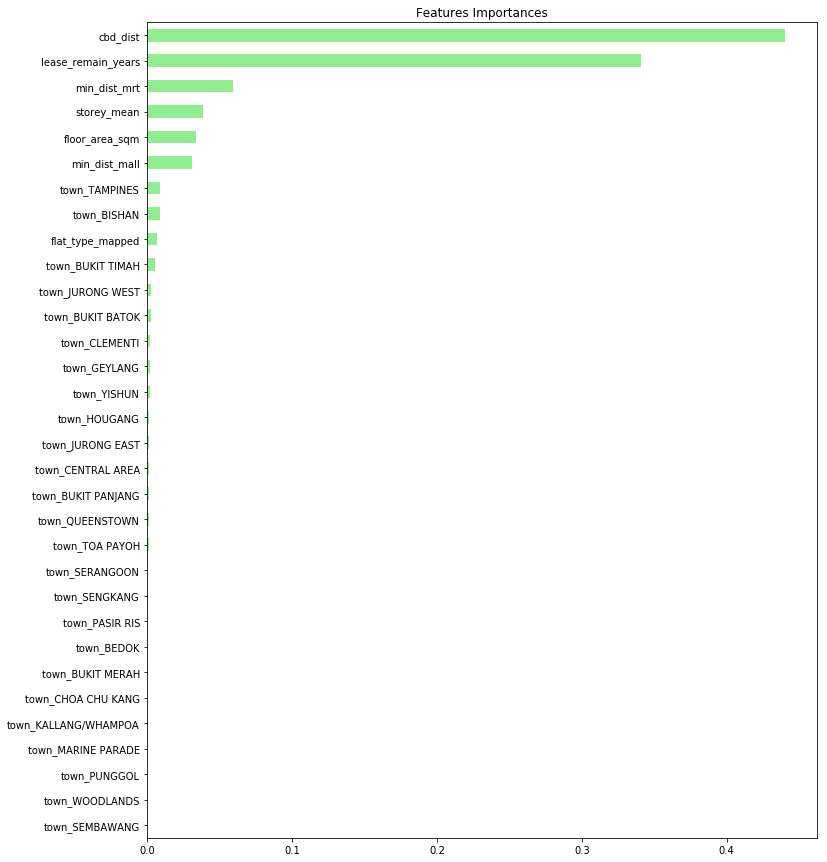

In [55]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(12,15))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [88]:
rf_cv_scores = cross_val_score(rf, X, y, cv=10, scoring="neg_mean_squared_error")

# Print the 10-fold cross-validation scores
print(rf_cv_scores)
lm_rf_score_rmse = abs(rf_cv_scores)**(1/2)
print(lm_rf_score_rmse)

print("Average 10-Fold CV Score: {}".format(np.mean(lm_rf_score_rmse)))

[-79742.09839952 -71257.36812508 -59744.75904166 -58745.1179836
 -56435.0935688  -46519.01977733 -29181.40401864 -25902.09913828
 -28142.00724192 -30834.34395037]
[282.38643452 266.94075771 244.42741058 242.37392183 237.56071554
 215.68268307 170.82565387 160.94129097 167.75579645 175.5971069 ]
Average 10-Fold CV Score: 216.4491771424585


## XGBoost Model

In [40]:
# Import xgboost
import xgboost as xgb

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective="reg:squarederror",n_estimator=10,seed=123)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

[11:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimator=10,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=123, silent=None, subsample=1, verbosity=1)

### XGBoost Model Evaluation

In [41]:
# Predict the labels of the test set: preds
pred_xgb = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse_test_xgb =(MSE(y_test, pred_xgb))**(1/2)
print("RMSE: %f" % (rmse_test_xgb))

RMSE: 415.112004


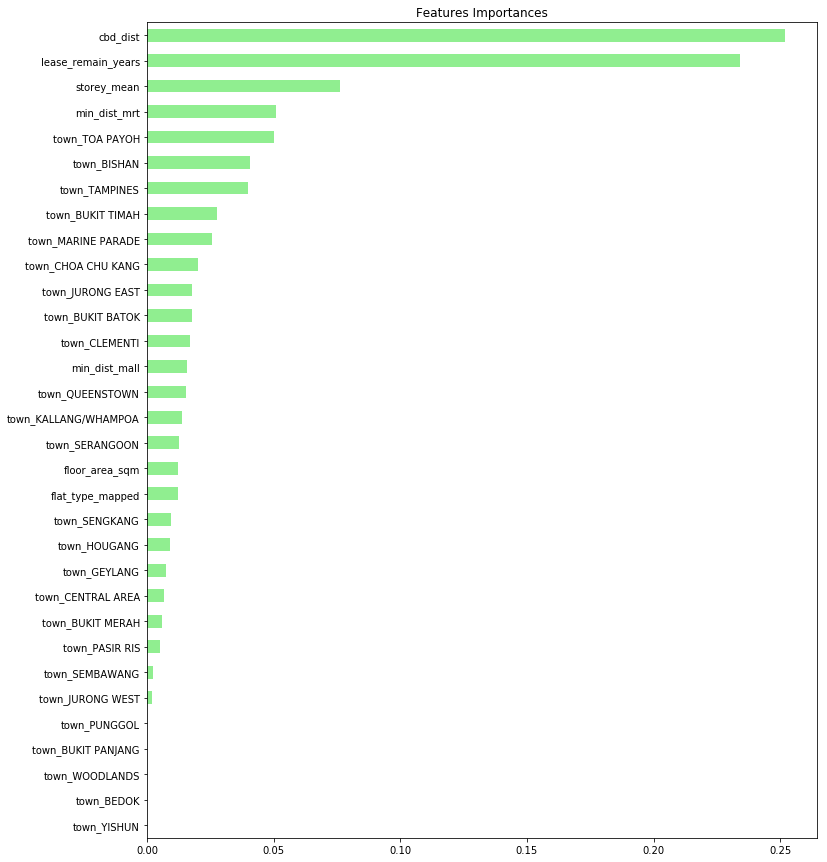

In [56]:
# Create a pd.Series of features importances
xgb_importances = pd.Series(data=xg_reg.feature_importances_,
                        index= X_train.columns)

# Sort importances
xgb_importances_sorted = xgb_importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(12,15))
xgb_importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [89]:
xgb_cv_scores = cross_val_score(xg_reg, X, y, cv=10, scoring="neg_mean_squared_error")

# Print the 10-fold cross-validation scores
print(xgb_cv_scores)
lm_xgb_score_rmse = abs(xgb_cv_scores)**(1/2)
print(lm_xgb_score_rmse)

print("Average 10-Fold CV Score: {}".format(np.mean(lm_xgb_score_rmse)))

[13:06:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n